In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import datetime, time, os, sys
from glob import glob
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cft
import xarray as xr
from matplotlib import rc
import cmocean as cm

from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
from trackeddy.plotfunc import *

In [2]:
dir = '/g/data/v45/mom/mom01v3/output055'
file = os.path.join(dir,'ocean.nc')

In [3]:
data = xr.open_dataset(file)

In [4]:
data

<xarray.Dataset>
Dimensions:                (nv: 2, st_edges_ocean: 51, st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50, time: 1, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * xt_ocean               (xt_ocean) float64 -279.9 -279.8 -279.7 -279.6 ...
  * yt_ocean               (yt_ocean) float64 -81.11 -81.07 -81.02 -80.98 ...
  * time                   (time) object   24-03-16 12:00:00
  * nv                     (nv) float64 1.0 2.0
  * xu_ocean               (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ...
  * yu_ocean               (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ...
  * st_ocean               (st_ocean) float64 5.034 15.1 25.22 35.36 45.58 ...
  * st_edges_ocean         (st_edges_ocean) float64 0.0 10.07 20.16 30.29 ...
  * sw_ocean               (sw_ocean) float64 10.07 20.16 30.29 40.47 50.71 ...
  * sw_edges_ocean         (sw_edges_ocean) float64 5.034 15.1 25.22 35.36 ...
    geolon_t               (yt_ocean, xt_ocean) float64 ..

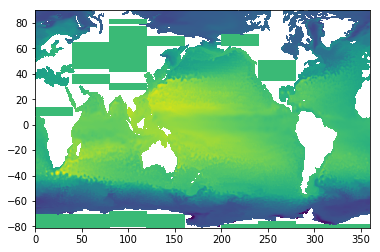

In [5]:
xx=find(data.xt_ocean.values,0)
ssh=np.hstack((np.squeeze(data.eta_t.values)[:,xx:],np.squeeze(data.eta_t.values)[:,0:xx]))
lon=np.linspace(0,360,len(data.xt_ocean.values))
#plt.pcolormesh(ssh)
lat=data.yt_ocean.values
mask=ma.getmask(data.eta_t.values)
plt.pcolormesh(lon,lat,ssh)

In [6]:
def geovelfield(ssha,lon,lat,mask,anomval=100):
    ma.filled(ssha,np.nan)
    distmlon=sw.dist(0,lon,'km')[0][:]*1000
    distmlat=sw.dist(0,lat,'km')[0][:]*1000
    mlon=np.cumsum(distmlon)
    mlat=np.cumsum(distmlat)
    dy=np.gradient(mlat)
    dx=np.gradient(mlon)
    detay,detax=np.gradient(ssha)
    omega = 7.2921e-5
    g=9.81
    f=2*omega*np.sin(np.deg2rad(lat))
    u=np.zeros(np.shape(ssha))
    v=np.zeros(np.shape(ssha))
    for ii in range(np.shape(ssha)[1]-1):
        detaxdy=detax[:,ii]/dx[ii]
        v[:,ii]=(g/f)*(detaxdy)
    for jj in range(np.shape(ssha)[0]-1):
        detaydx=detay[jj,:]/dy[jj]
        u[jj,:]=-(g/f[jj])*(detaydx)
    u[u>anomval]=np.nan
    v[v>anomval]=np.nan
    u[u<-anomval]=np.nan
    v[v<-anomval]=np.nan
    u= np.ma.masked_array(u, mask)
    v= np.ma.masked_array(v, mask)
    return u,v

In [7]:
u_g,v_g=geovelfield(np.squeeze(ssh),lon,lat,mask,10)


In [8]:
vort=vorticity2D(u_g, v_g, lon, lat)

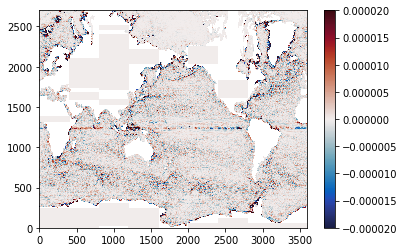

In [9]:
plt.pcolormesh(vort,vmin=-2e-5,vmax=2e-5,cmap=cm.cm.balance)
plt.colorbar()

In [10]:
satfile='/g/data/ua8/CMEMS_SeaLevel/v3-0/2016/dt_global_allsat_phy_l4_20160316_20170110.nc'

In [11]:
data = xr.open_dataset(satfile)
data

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2016-03-16T00:02:11.347054592
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 -89.125 -88.875 ...
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
  * nv         (nv) int32 0 1
Data variables:
    crs        int32 ...
    lat_bnds   (latitude, nv) float32 ...
    lon_bnds   (longitude, nv) float32 ...
    sla        (time, latitude, longitude) float64 ...
    err        (time, latitude, longitude) float64 ...
    ugosa      (time, latitude, longitude) float64 ...
    vgosa      (time, latitude, longitude) float64 ...
    adt        (time, latitude, longitude) float64 ...
    ugos       (time, latitude, longitude) float64 ...
    vgos       (time, latitude, longitude) float64 ...
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_ty

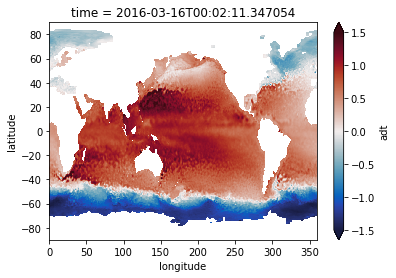

In [12]:
data.adt.plot(vmin=-1.5,vmax=1.5,cmap=cm.cm.balance)

In [13]:
vortsat=vorticity2D(np.squeeze(data.ugos.values), np.squeeze(data.vgos.values),\
                 data.longitude.values, data.latitude.values)

lats=data.latitude.values
lons=data.longitude.values

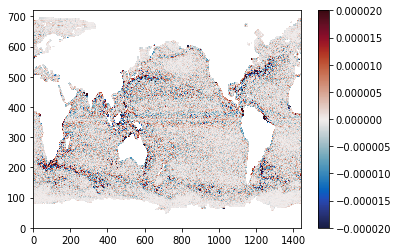

In [14]:
plt.pcolormesh(vortsat,vmin=-2e-5,vmax=2e-5,cmap=cm.cm.balance)
plt.colorbar()

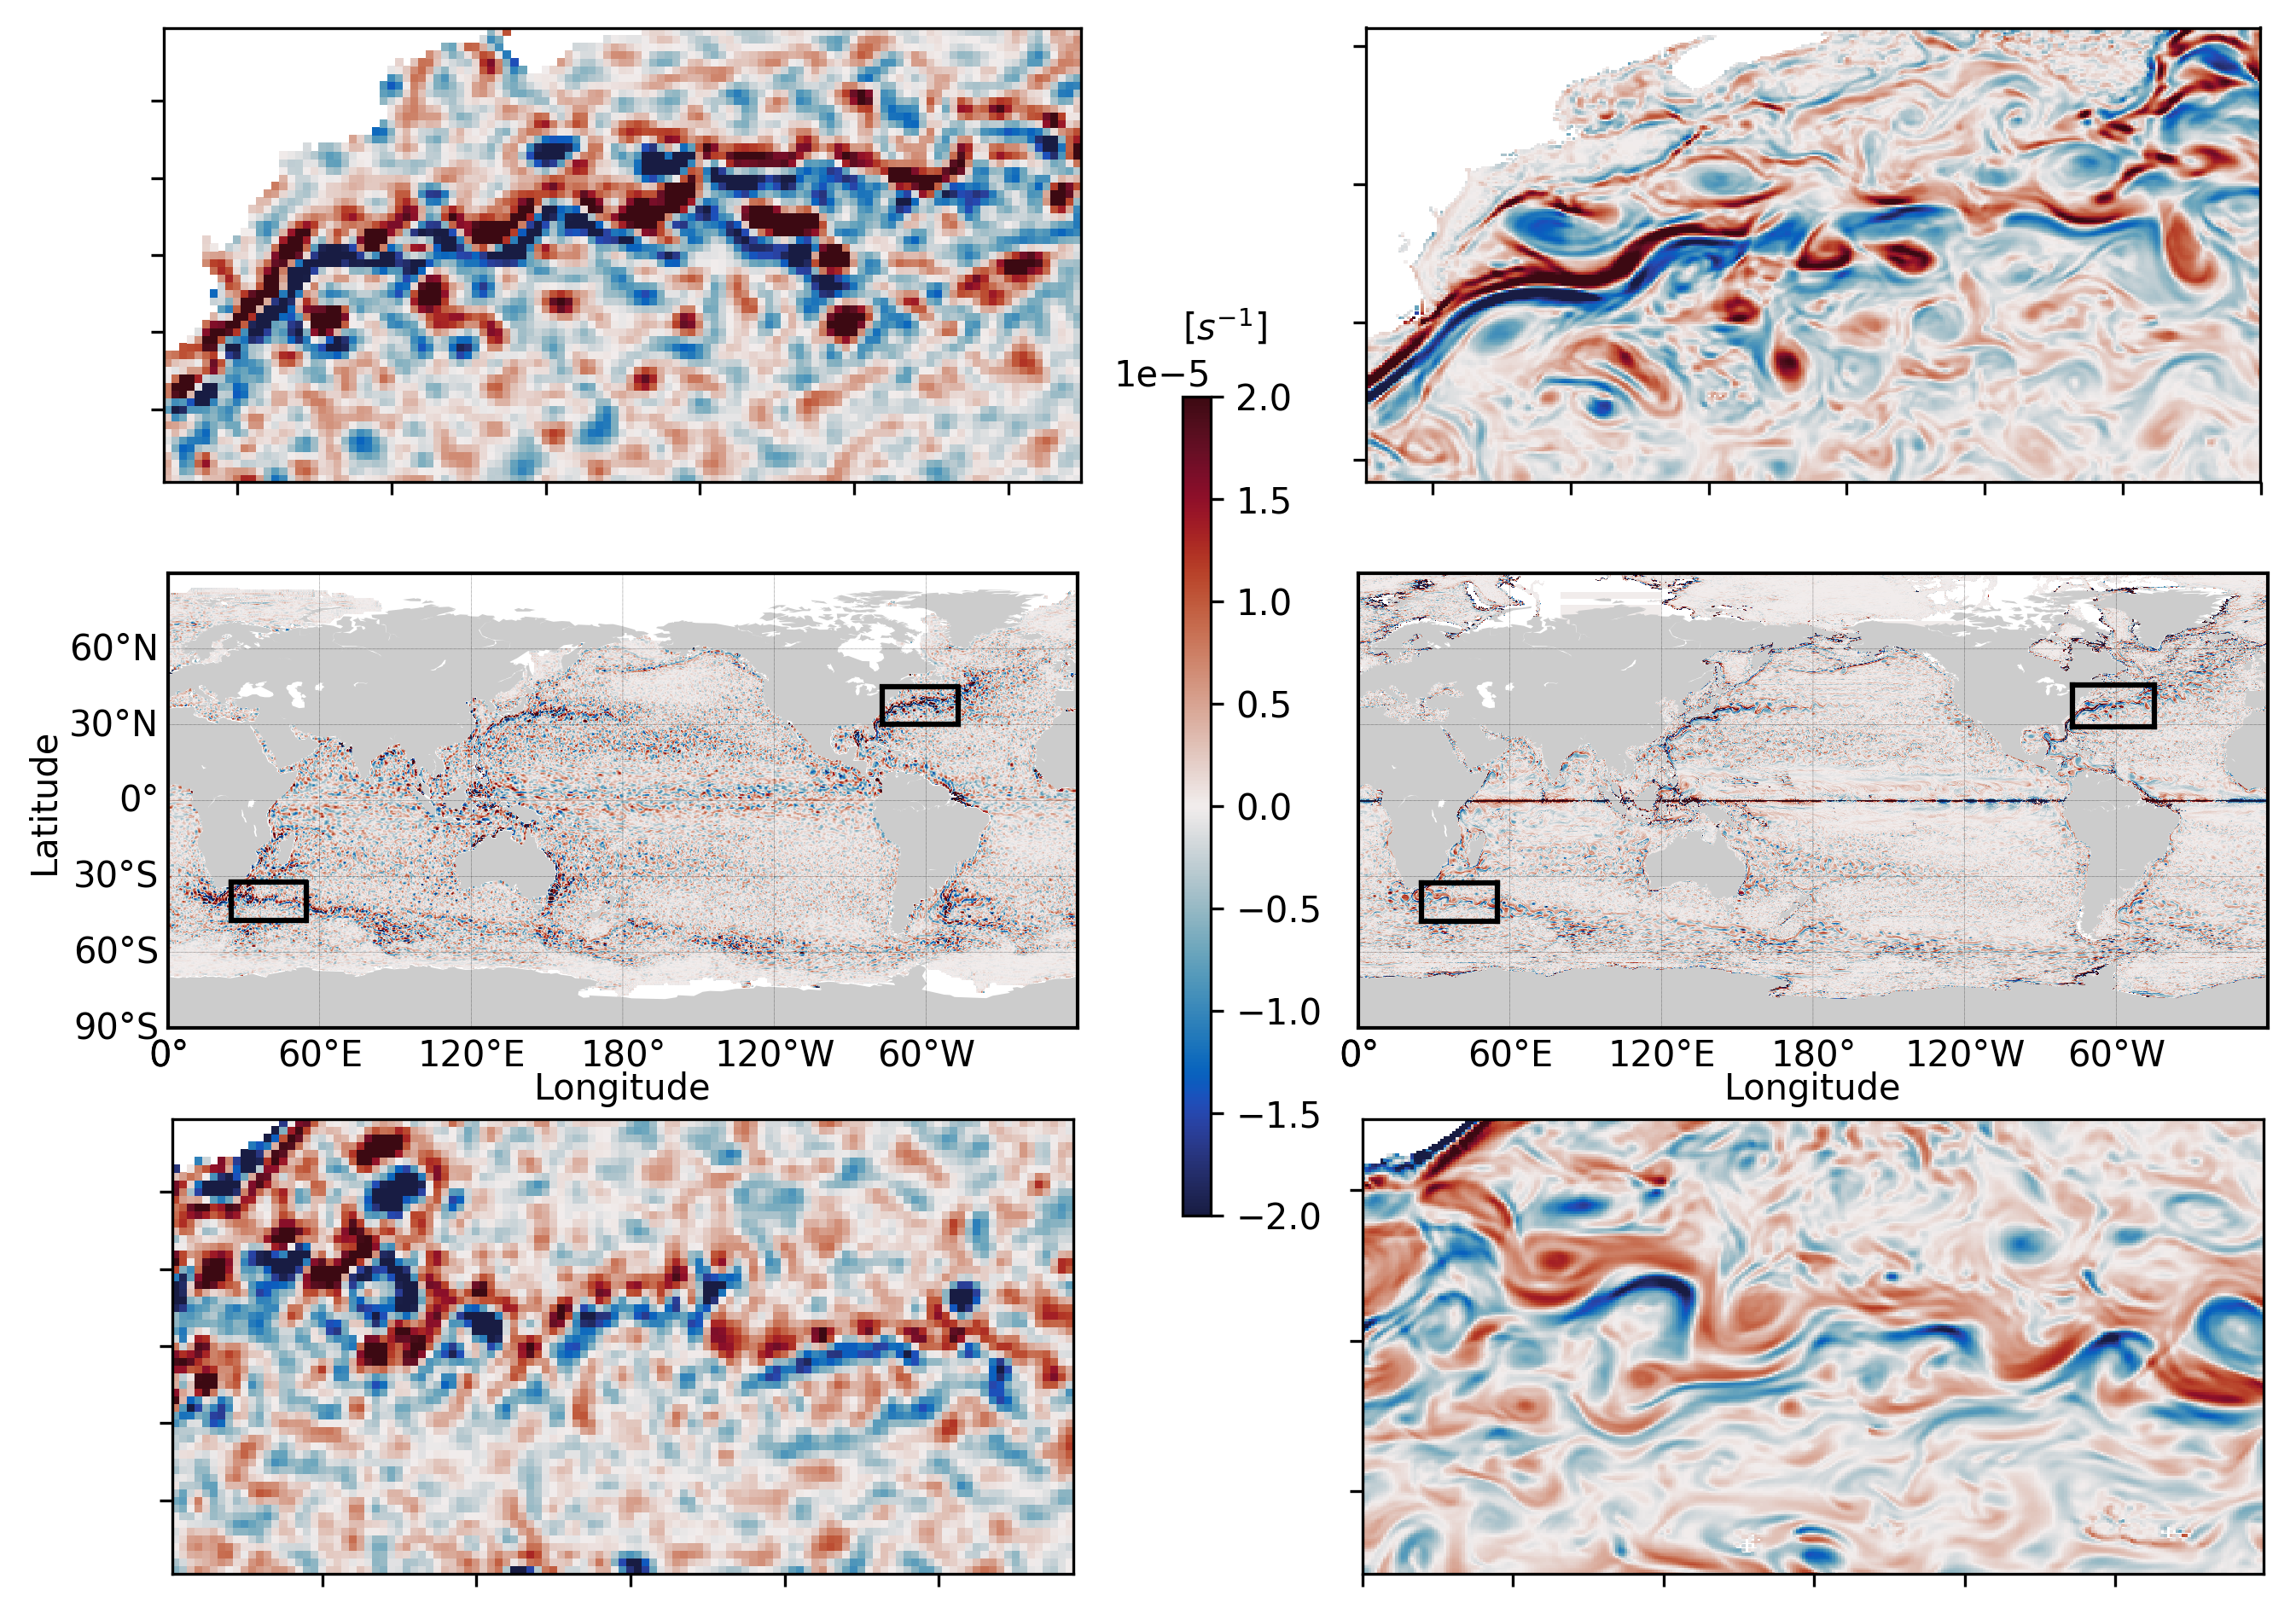

In [18]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

import numpy as np


#fig, ax = plt.subplots(2,2,figsize=[8,4],dpi=300)
fig = plt.figure(figsize=[11,8],dpi=300)
gs = gridspec.GridSpec(3, 2, height_ratios=[3,3,3]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])
ax6 = plt.subplot(gs[5])

### Regional plot
ax1.pcolormesh(lons[1130:1250],lats[480:540],vortsat[480:540,1130:1250],\
               vmin=-2e-5,vmax=2e-5,cmap=cm.cm.balance)
ax5.pcolormesh(lons[100:218],lats[170:230],vortsat[170:230,100:218],\
               vmin=-2e-5,vmax=2e-5,cmap=cm.cm.balance)
ax1.set_aspect('equal')
ax5.set_aspect('equal')

### Global Plot
map = Basemap(projection='cyl',ax=ax3,llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360)
map.drawmapboundary()
map.fillcontinents()
map.drawparallels(range(-90, 90, 30),linewidth=0.1, labels=[1,0,0,1],fontsize=10)
map.drawmeridians(range(0, 360, 60),linewidth=0.1, labels=[1,0,0,1],fontsize=10)
LON,LAT=map(lons,lats)
map.pcolormesh(LON,LAT,vortsat,vmin=-2e-5,vmax=2e-5,cmap=cm.cm.balance)
map.plot(LON[1130:1250],np.ones(len(LON[1130:1250]))*LAT[480],'-k')
map.plot(LON[1130:1250],np.ones(len(LON[1130:1250]))*LAT[540],'-k')
map.plot(LON[1130]*np.ones(len(LAT[480:540])),LAT[480:540],'-k')
map.plot(LON[1250]*np.ones(len(LAT[480:540])),LAT[480:540],'-k')

map.plot(LON[100:218],np.ones(len(LON[100:218]))*LAT[170],'-k')
map.plot(LON[100:218],np.ones(len(LON[100:218]))*LAT[230],'-k')
map.plot(LON[100]*np.ones(len(LAT[170:230])),LAT[170:230],'-k')
map.plot(LON[218]*np.ones(len(LAT[170:230])),LAT[170:230],'-k')
ax3.set_xlabel('Longitude',labelpad=12)
ax3.set_ylabel('Latitude',labelpad=30)

### Regional plot
ax2.pcolormesh(lon[2825:3150],lat[1550:1760],vort[1550:1760,2825:3150],\
               vmin=-2e-5,vmax=2e-5,cmap=cm.cm.balance)
ax2.set_aspect('equal')
ax6.pcolormesh(lon[250:550],lat[700:900],vort[700:900,250:550],\
               vmin=-2e-5,vmax=2e-5,cmap=cm.cm.balance)
ax6.set_aspect('equal')

### Global Plot
map = Basemap(projection='cyl',ax=ax4,llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=0,urcrnrlon=360)
map.drawmapboundary()
map.fillcontinents()
map.drawparallels(range(-90, 90, 30),linewidth=0.1, labels=[0,0,0,0],fontsize=10)
map.drawmeridians(range(0, 360, 60),linewidth=0.1, labels=[1,0,0,1],fontsize=10)
LON,LAT=map(lon,lat)
cbarp=map.pcolormesh(LON,LAT,vort,vmin=-2e-5,vmax=2e-5,cmap=cm.cm.balance)
map.plot(LON[2825:3150],np.ones(len(LON[2825:3150]))*LAT[1550],'-k')
map.plot(LON[2825:3150],np.ones(len(LON[2825:3150]))*LAT[1760],'-k')
map.plot(LON[2825]*np.ones(len(LAT[1550:1760])),LAT[1550:1760],'-k')
map.plot(LON[3150]*np.ones(len(LAT[1550:1760])),LAT[1550:1760],'-k')

map.plot(LON[250:550],np.ones(len(LON[250:550]))*LAT[700],'-k')
map.plot(LON[250:550],np.ones(len(LON[250:550]))*LAT[900],'-k')
map.plot(LON[250]*np.ones(len(LAT[700:900])),LAT[700:900],'-k')
map.plot(LON[550]*np.ones(len(LAT[700:900])),LAT[700:900],'-k')
ax4.set_xlabel('Longitude',labelpad=12)


plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=False)
plt.setp(ax6.get_xticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.setp(ax6.get_yticklabels(), visible=False)

cax = fig.add_axes([0.5, 0.3, 0.01, 0.4])
cb=fig.colorbar(cbarp, cax=cax, orientation='vertical')
cb.formatter.set_powerlimits((0, 0))
cb.ax.yaxis.set_offset_position('right')
cb.update_ticks()
cb.ax.text(0,1.07,'$[s^{-1}]$')

plt.show()

In [ ]:
#plt.pcolormesh(vortsat[150:250,100:200])
plt.pcolormesh(vortsat[480:540,1130:1250])

In [ ]:
#plt.pcolormesh(vort[700:900,250:550])
plt.pcolormesh(vort[1600:1760,2825:3100])
